In [185]:
%load_ext autoreload
%autoreload 2

import sys
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

sys.path.append('../../../')
from forward_model.ics import get_delta
from forward_model.fourier import get_k, my_fft, my_ifft
from forward_model.lpt import get_forward_lpt, get_psi_lpt1
from forward_model.plot_utils import plot_cubes, compare_pow_spec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [186]:
N, L, Z_I, Z_F = 128, 180, 99, 0

SEED_INT = 1
key = jax.random.PRNGKey(SEED_INT)
input_arr = jax.random.normal(key, shape=(N,) * 3)

INPUT_ARG = "FSK_U"
LPT_METHOD = "ALPT"
R_S = 4
MUSCLE = False
MUSCLE_ITERS = "ONE"
SC_CORRECTION = True

get_forward_lpt_ = partial(
    get_forward_lpt,
    N,
    L,
    Z_I,
    Z_F,
    IC_KIND=INPUT_ARG,
    MUSCLE=MUSCLE,
    MUSCLE_ITERS=MUSCLE_ITERS,
    R_S=R_S,
    SC_CORRECTION=SC_CORRECTION,
)

forward_lpt = get_forward_lpt_(
    LPT_METHOD=LPT_METHOD,
)
delta_alpt = forward_lpt(input_arr)

(0.1, np.float64(2.6935851905234127))

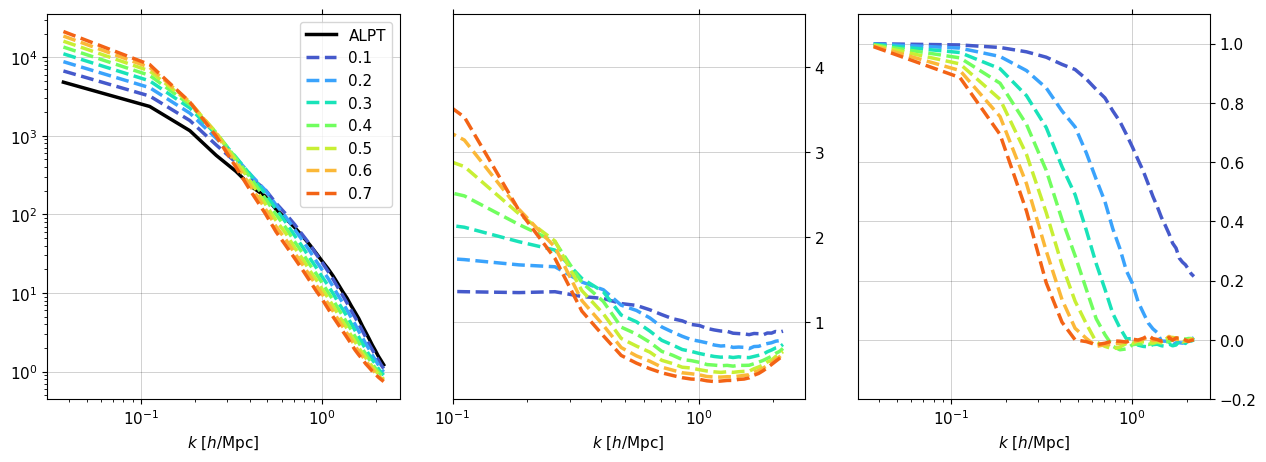

In [191]:
K_TH_PR = 0.2
d_pr_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

delta_prs = []
for d_pr in d_pr_list:
    

    forward_lpt = get_forward_lpt_(
        LPT_METHOD=LPT_METHOD,
        PARTICLE_RIDGE=True,
        K_TH_PR=K_TH_PR,
        D_PR=d_pr,
    )
    delta_alpt_pr = forward_lpt(input_arr)
    delta_prs.append(delta_alpt_pr)

fig, axs = compare_pow_spec(
    [delta_alpt] + delta_prs, L, n_bins=30, labels=["ALPT"] + d_pr_list, xlog=True, sphere_only=True
)

axs[1].set_xlim(0.1, None)

(<Figure size 707.107x353.553 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

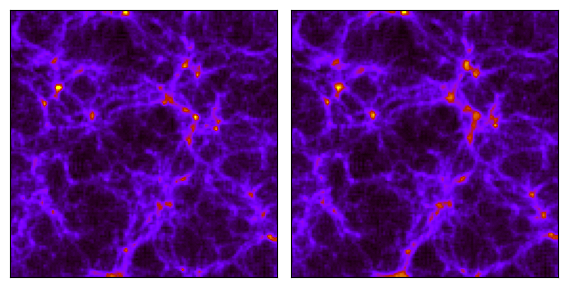

In [190]:
plot_cubes([delta_alpt, delta_prs[0]], cmap='gnuplot', vlim=(-1, 10), idx=N//2, axis=2, width=15)

(0.1, np.float64(4.820198470611299))

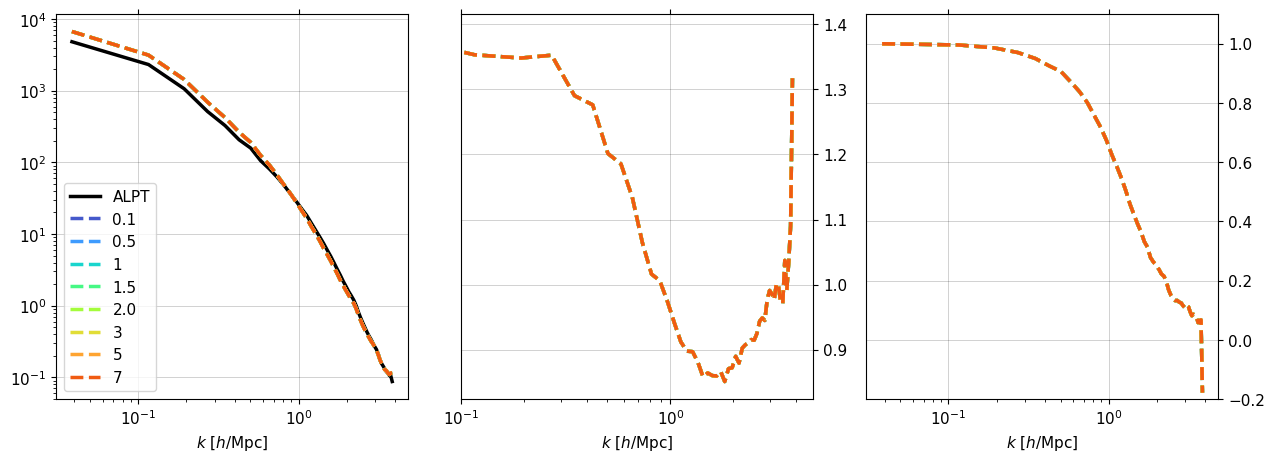

In [192]:
k_th_list = [0.1, 0.5, 1, 1.5, 2. ,3, 5, 7]
D_PR = 0.1

delta_prs = []
for K_TH in k_th_list:

    forward_lpt = get_forward_lpt_(
        LPT_METHOD=LPT_METHOD,
        PARTICLE_RIDGE=True,
        K_TH_PR=K_TH,
        D_PR=D_PR,
    )
    delta_alpt_pr = forward_lpt(input_arr)
    delta_prs.append(delta_alpt_pr)

fig, axs = compare_pow_spec(
    [delta_alpt]+delta_prs, L, n_bins=50, labels=["ALPT"]+k_th_list, xlog=True
)

axs[1].set_xlim(0.1, None)

(<Figure size 707.107x353.553 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

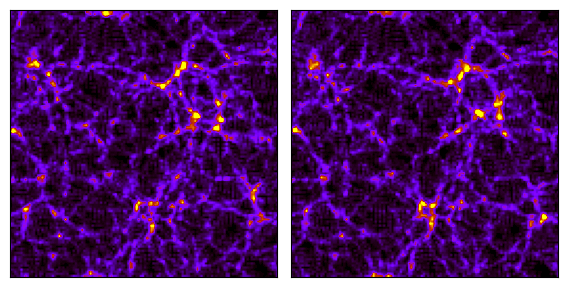

In [197]:
plot_cubes([delta_alpt, delta_prs[-1]], cmap='gnuplot', vlim=(-1, 10), idx=N//2, axis=2, width=1)

In [ ]:
N, L, Z_I, Z_F = 128, 120, 99, 0

SEED_INT = 1
key = jax.random.PRNGKey(SEED_INT)
input_arr = jax.random.normal(key, shape=(N**3,))

INPUT_ARG = "GAUSSIAN_NCUBE_NUMBERS_FLAT"
LPT_METHOD = "ALPT"
R_S = 4
MUSCLE = True
MUSCLE_ITERS = "MANY"

forward_lpt = get_forward_lpt(
    N,
    L,
    Z_I,
    Z_F,
    LPT_METHOD=LPT_METHOD,
    INPUT_ARG=INPUT_ARG,
    MUSCLE=MUSCLE,
    MUSCLE_ITERS=MUSCLE_ITERS,
    R_S=R_S
)

delta_fin = forward_lpt(input_arr)

In [ ]:
x = jnp.linspace(-100,100,1000)

erf = jax.lax.erf(x)

print(jnp.min(erf))
print(jnp.max(erf))

y = jax.lax.erfc(x)

print(jnp.min(y))
print(jnp.max(y))


0.99996835


(<Figure size 866.025x288.675 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

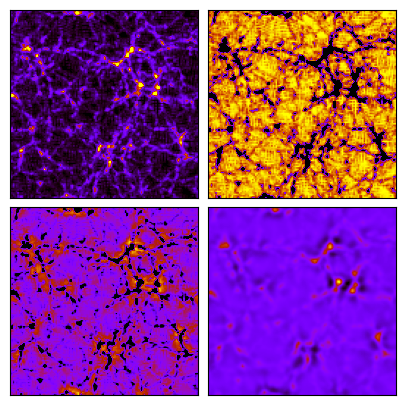

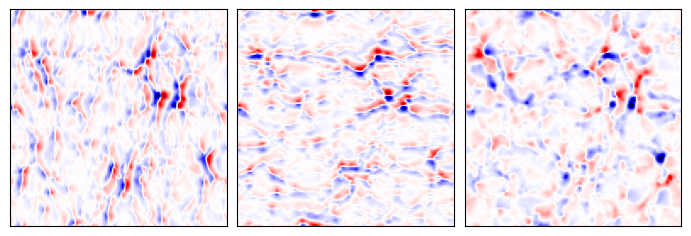

In [184]:
k = get_k(N, L)

k_cut = 0.4
sigma = 0.1
u = (k-k_cut) / (jnp.sqrt(2) * sigma)

erfc_filter_hat = jax.lax.erfc(u)*0.5
print(jnp.max(erfc_filter_hat))

div_psi = 3 * jnp.real(1-2/3 * delta_alpt.astype(complex)) - 3
div_psi_hat = my_fft(div_psi, L)
div_psi_hat_residual = (1 - erfc_filter_hat) * div_psi_hat
div_psi_residual = my_ifft(div_psi_hat_residual, L)

one_over_k_sq = jnp.where(k > 0, 1 / k**2, 0.0)

phi_hat = -div_psi_hat * one_over_k_sq
phi_residual_hat = -div_psi_hat_residual * one_over_k_sq
phi_residual = my_ifft(phi_residual_hat, L)


psi_res_x_hat, psi_res_y_hat, psi_res_z_hat = get_psi_lpt1(
    -phi_residual_hat, N, L
)
psi_res_x = my_ifft(psi_res_x_hat, L)
psi_res_y = my_ifft(psi_res_y_hat, L)
psi_res_z = my_ifft(psi_res_z_hat, L)
#plt.plot(k[:,0,0], erfc_filter_hat[:,0,0])
#delta_fin_hat = my_fft(delta_alpt, L)

# delta_fin_hat_smooth = delta_fin_hat * erfc_filter_hat
# delta_fin_smooth = my_ifft(delta_fin_hat_smooth, L)

# delta_fin_hat_sharp = (delta_fin_hat - delta_fin_hat_smooth)*(-1)
# delta_fin_sharp = my_ifft(delta_fin_hat_sharp, L)

plot_cubes([delta_alpt, div_psi, div_psi_residual, phi_residual], cmap='gnuplot', vlim=[(-1, 10),(-3,None), (-3,None), (None, None)], idx=N//2, axis=2, width=1)

plot_cubes([psi_res_x, psi_res_y, psi_res_z], cmap='seismic_r', vlim=20,  idx=N//2, axis=2, width=1)